In [39]:
import joblib
import os
import pandas as pd
import numpy as np
#Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import dtreeviz
#modelos y métricas
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score#, precision_recall_curve, roc_curve,
from sklearn.metrics import confusion_matrix, classification_report
#preprocesamiento
from sklearn.preprocessing import MinMaxScaler
#configuración warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

### Carga del dataset

In [40]:
ruta_hotels_train = os.path.join("..", "..", "Datasets", "hotels_train.csv")
ruta_hotels_test = os.path.join("..", "..", "Datasets", "hotels_test.csv")
ds_hotels_train = pd.read_csv(ruta_hotels_train)
ds_hotels_test = pd.read_csv(ruta_hotels_test)
df_hotels_train = ds_hotels_train.copy()
df_hotels_test = ds_hotels_test.copy()

### Preprocesamiento

#### Datos nulos

Porcentaje de datos nulos

In [41]:
df_hotels_train.isna().sum() / df_hotels_train.shape[0] * 100

hotel                              0.000000
lead_time                          0.000000
arrival_date_year                  0.000000
arrival_date_month                 0.000000
arrival_date_week_number           0.000000
arrival_date_day_of_month          0.000000
stays_in_weekend_nights            0.000000
stays_in_week_nights               0.000000
adults                             0.000000
children                           0.006461
babies                             0.000000
meal                               0.000000
country                            0.356952
market_segment                     0.000000
distribution_channel               0.000000
is_repeated_guest                  0.000000
previous_cancellations             0.000000
previous_bookings_not_canceled     0.000000
reserved_room_type                 0.000000
assigned_room_type                 0.000000
booking_changes                    0.000000
deposit_type                       0.000000
agent                           

Se elimina la columna "company" por el gran porcentaje de datos nulos.
Tambien todas la filas con algun datos nulo.

In [42]:
# Train
df_hotels_train.drop("company", axis="columns", inplace=True)
df_hotels_train.dropna(inplace=True)
# Test
df_hotels_test.drop("company", axis="columns", inplace=True)
df_hotels_test.dropna(inplace=True)

Conversion de meses a su valor numerico

In [43]:
mes_numero = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}

# Train
df_hotels_train["arrival_date_month"] = df_hotels_train["arrival_date_month"].map(mes_numero)
# Test
df_hotels_test["arrival_date_month"] = df_hotels_test["arrival_date_month"].map(mes_numero)

#### Outliers

Limpieza de datos invalidos

Borrado de la fila que contiene el valor 10 de la columna "children"

In [44]:
df_hotels_train.drop(df_hotels_train[df_hotels_train["children"] == 10].index, inplace=True)

Borrado de la fila que contiene el  valor 9 de la columna "babies"

In [45]:
df_hotels_train.drop(df_hotels_train[df_hotels_train["babies"] == 9].index, inplace=True)

Borrado de filas que continen los valores Complementary y Aviation de la columna "market_segment"

In [46]:
# Train
df_hotels_train.drop(df_hotels_train[df_hotels_train["market_segment"] == "Aviation"].index, inplace=True)
df_hotels_train.drop(df_hotels_train[df_hotels_train["market_segment"] == "Complementary"].index, inplace=True)
# Test
df_hotels_test.drop(df_hotels_test[df_hotels_test["market_segment"] == "Aviation"].index, inplace=True)
df_hotels_test.drop(df_hotels_test[df_hotels_test["market_segment"] == "Complementary"].index, inplace=True)

Borrado de las filas que contienen los valores mayores 8 de la columna "booking_changes"

In [47]:
df_filas = df_hotels_train[8 < df_hotels_train['booking_changes']]
df_hotels_train.drop(df_filas.index, inplace=True)

Borrado de filas con los valores Refundable en la columna "deposit_type"

In [48]:
# Train
df_filas = df_hotels_train[df_hotels_train["deposit_type"] == "Refundable"]
df_hotels_train.drop(df_filas.index, inplace=True)
# Test
df_filas = df_hotels_test[df_hotels_test["deposit_type"] == "Refundable"]
df_hotels_test.drop(df_filas.index, inplace=True)

Borrado de una fila que contenia una valor menor a cero

In [49]:
df_fila = df_hotels_train[df_hotels_train["adr"] < 0]
df_hotels_train.drop(df_fila.index, inplace=True)

Borrado de las filas cuyos valores son 2 y 3 en al columna "requiered_car_parking_spaces"

In [50]:
df_filas = df_hotels_train[(df_hotels_train["required_car_parking_spaces"] == 2) | (df_hotels_train["required_car_parking_spaces"] == 3)]
df_hotels_train.drop(df_filas.index, inplace=True)

Borrado de las filas cuyos valores son 5 en la columna "total_of_special_request"

In [51]:
df_filas = df_hotels_train[df_hotels_train["total_of_special_requests"] == 5]
df_hotels_train.drop(df_filas.index, inplace=True)

Borrado de las filas cuyos valores son mayores a 375 en la columna "lead_time"

In [52]:
df_filas = df_hotels_train[375 < df_hotels_train["lead_time"]]
df_hotels_train.drop(df_filas.index, inplace=True)

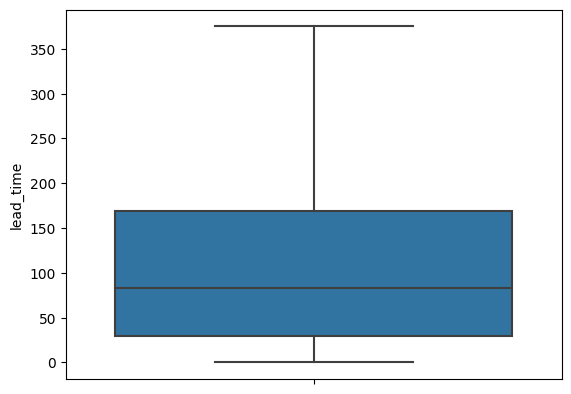

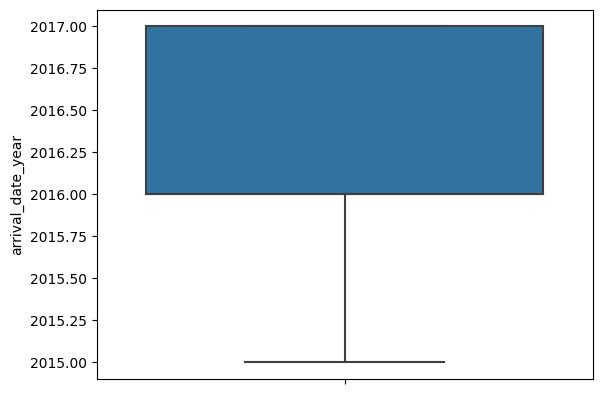

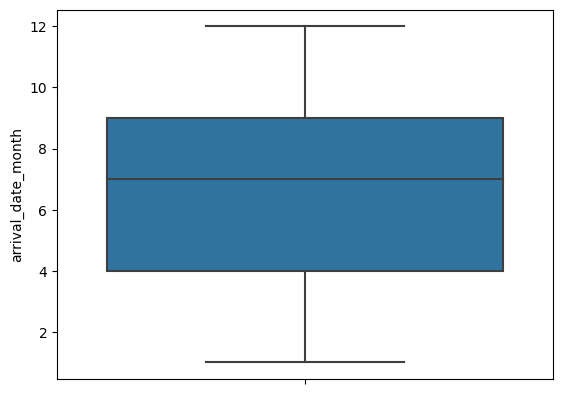

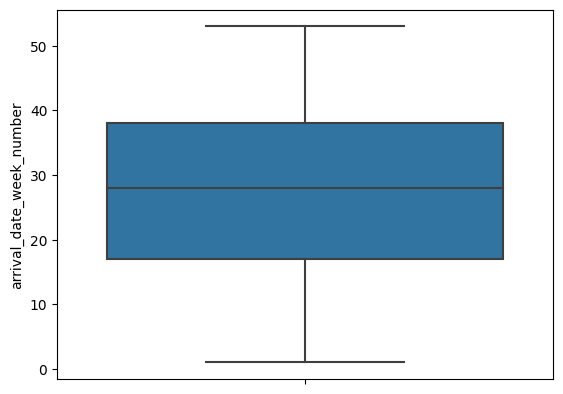

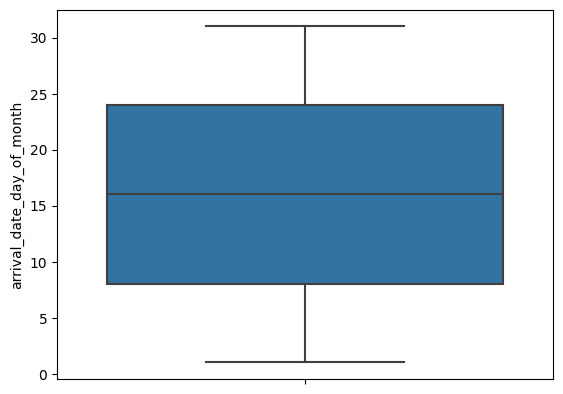

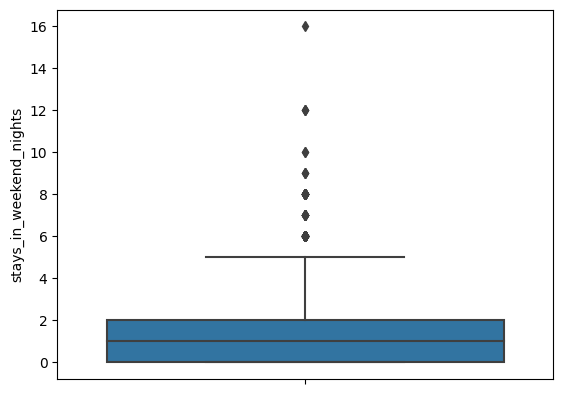

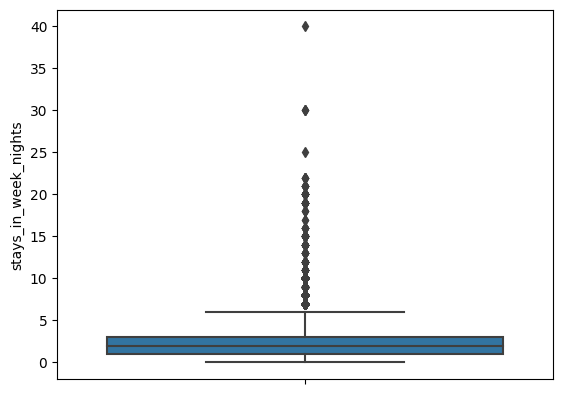

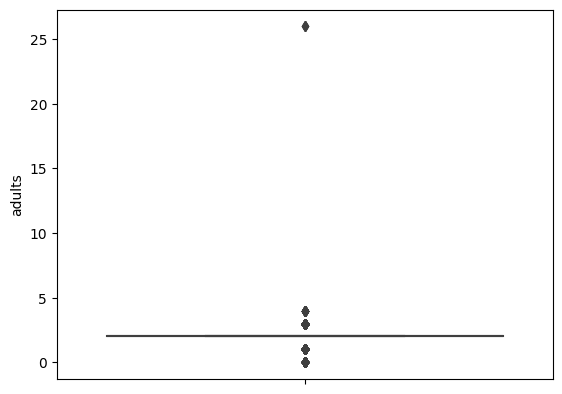

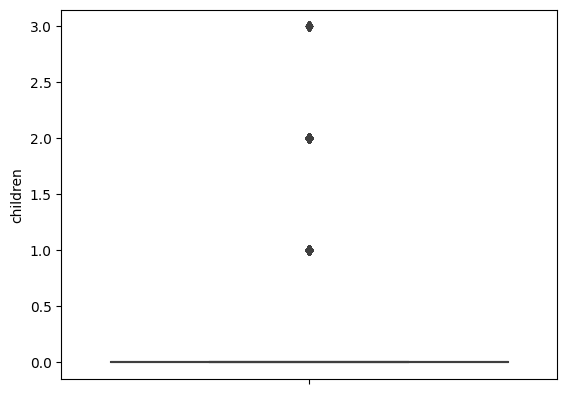

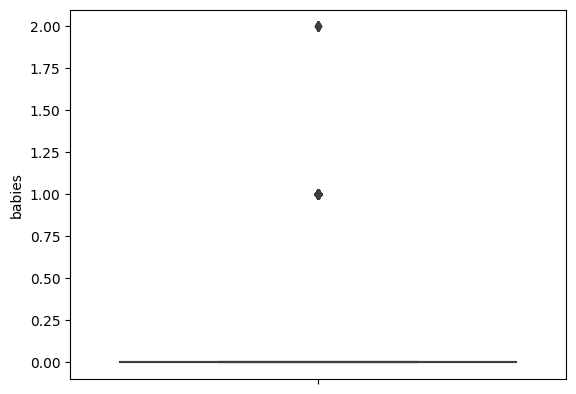

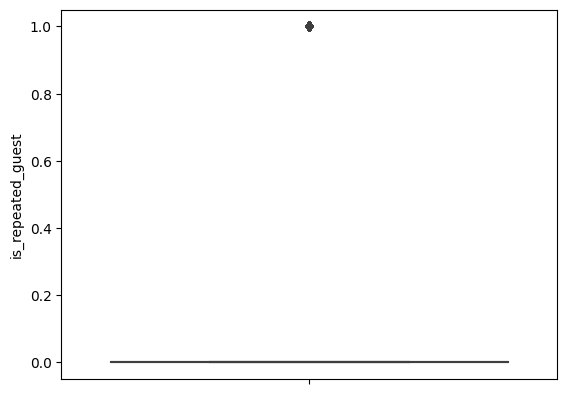

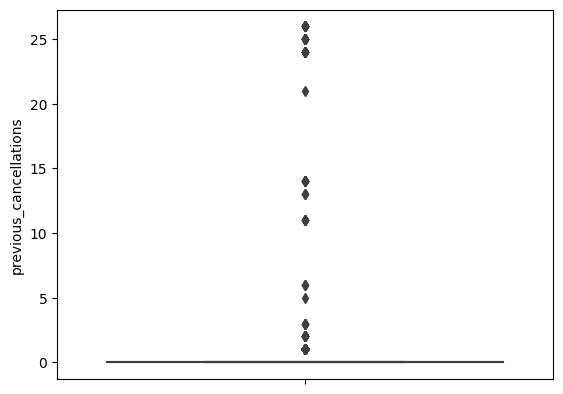

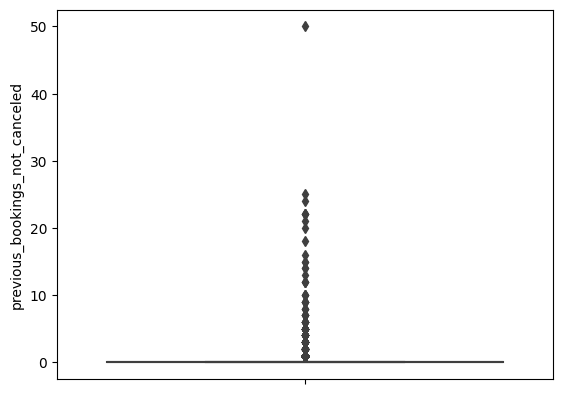

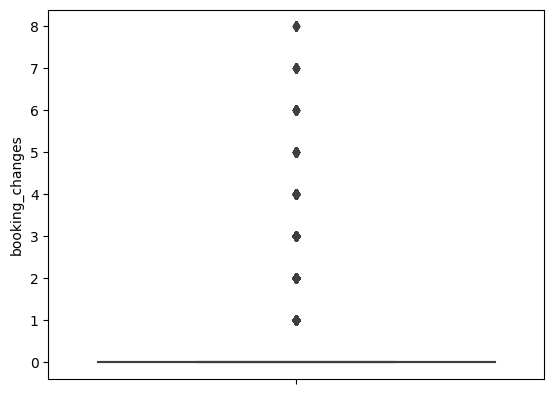

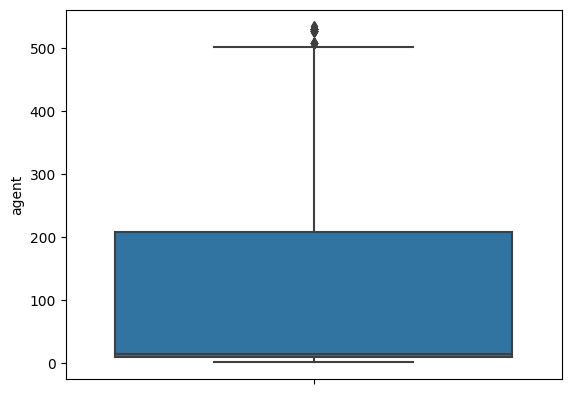

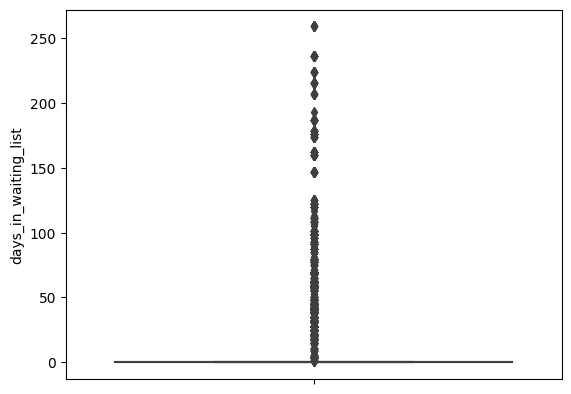

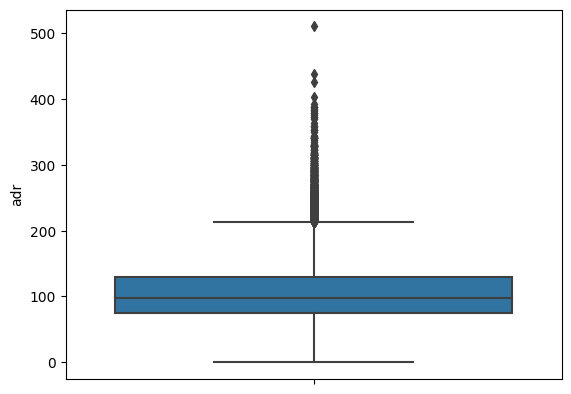

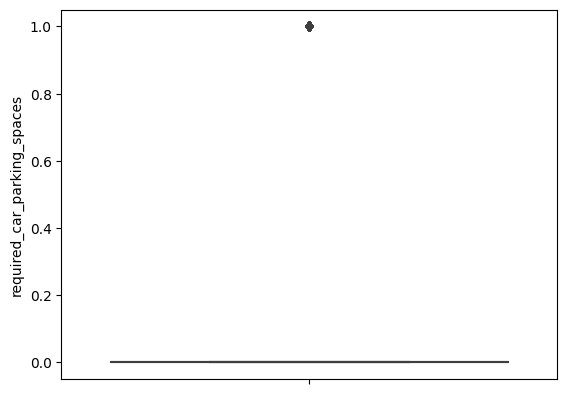

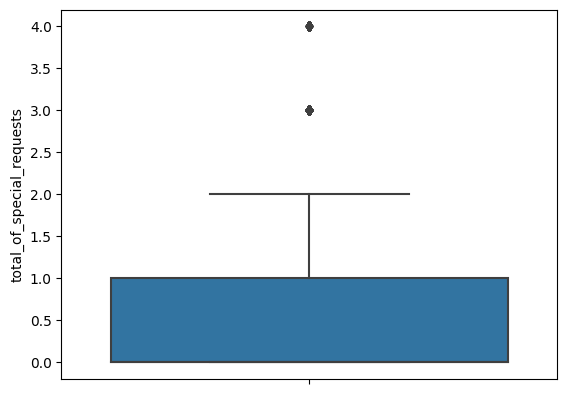

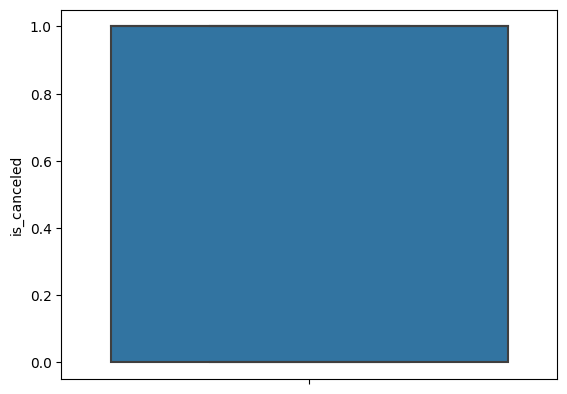

In [53]:
columnas_numericas = df_hotels_train.select_dtypes(include=['number']).columns.tolist()
for columna in columnas_numericas:
    sns.boxplot(data=df_hotels_train, y=columna)
    plt.show()

#### Seleccion de variables

Variables que no voy a tener en cuenta

In [54]:
columnas = ["meal"]
# Train
df_hotels_train.drop(columnas, axis="columns", inplace=True)
# Test
df_hotels_test.drop(columnas, axis="columns", inplace=True)
df_hotels_test.drop("reservation_status_date", axis="columns", inplace=True)

One hot encoding para variables categoricas

Emparejo el dataframe de train y test para que tengan las mismas columnas

In [55]:
df_paises_train = df_hotels_train["country"].unique()
df_paises_test = df_hotels_test["country"].unique()
# Intersección de países comunes en ambos conjuntos
paises_interseccion = set(df_paises_train) & set(df_paises_test)
# Filtra train y test para incluir solo los países comunes
df_hotels_train = df_hotels_train[df_hotels_train["country"].isin(paises_interseccion)]
df_hotels_test = df_hotels_test[df_hotels_test["country"].isin(paises_interseccion)]

In [56]:
df_hotels_train = pd.get_dummies(df_hotels_train, columns=["hotel", "country", "market_segment", "distribution_channel", "reserved_room_type", "assigned_room_type", "deposit_type", "customer_type"], drop_first=True)
df_hotels_test = pd.get_dummies(df_hotels_test, columns=["hotel", "country", "market_segment", "distribution_channel", "reserved_room_type", "assigned_room_type", "deposit_type", "customer_type"], drop_first=True)
df_hotels_train.head(3)

,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,assigned_room_type_E,assigned_room_type_F,assigned_room_type_G,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K,deposit_type_Non Refund,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,49,2016,9,37,5,1,2,1,0.0,0,...,False,False,False,False,False,False,False,False,True,False
2,25,2016,10,42,13,0,1,2,2.0,0,...,False,True,False,False,False,False,False,False,True,False
3,26,2016,12,51,12,2,5,2,0.0,0,...,False,False,False,False,False,False,True,False,True,False


Elimino la variable "id"

In [57]:
# Train
s_id_train = df_hotels_train.pop("id")
# Test
s_id_test = df_hotels_test.pop("id")

Asi queda el data frame:

In [58]:
df_hotels_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52039 entries, 0 to 61912
Columns: 166 entries, lead_time to customer_type_Transient-Party
dtypes: bool(146), float64(3), int64(17)
memory usage: 15.6 MB


### Entrenamiento y prediccion

Creo un data frame con las features que voy a usar para clasificar

In [59]:
df_trabajo_x = df_hotels_train.drop(["is_canceled"], axis="columns", inplace=False)
df_trabajo_x.head(3)

,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,assigned_room_type_E,assigned_room_type_F,assigned_room_type_G,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K,deposit_type_Non Refund,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,49,2016,9,37,5,1,2,1,0.0,0,...,False,False,False,False,False,False,False,False,True,False
2,25,2016,10,42,13,0,1,2,2.0,0,...,False,True,False,False,False,False,False,False,True,False
3,26,2016,12,51,12,2,5,2,0.0,0,...,False,False,False,False,False,False,True,False,True,False


Creo una serie con la variable target

In [60]:
s_trabajo_y = df_hotels_train["is_canceled"].copy()
s_trabajo_y.head(3)

0    1
2    0
3    1
Name: is_canceled, dtype: int64

Genero los conjuntos de train y de  test

In [61]:
x_train, x_test, y_train, y_test = train_test_split(df_trabajo_x, s_trabajo_y, test_size=0.3, random_state=2)

In [62]:
x_train.head(3)

,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,assigned_room_type_E,assigned_room_type_F,assigned_room_type_G,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K,deposit_type_Non Refund,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
30726,242,2016,10,44,28,2,2,2,1.0,0,...,False,False,False,False,False,False,False,False,True,False
33771,70,2016,6,23,3,0,2,2,0.0,0,...,False,False,False,False,False,False,False,False,False,True
40569,2,2017,8,33,18,2,3,2,0.0,0,...,False,False,False,False,False,False,False,False,True,False


In [63]:
y_train.head(3)

30726    0
33771    0
40569    0
Name: is_canceled, dtype: int64

Creo un clasificador con hiperparametros

In [64]:
arbol = tree.DecisionTreeClassifier(criterion="gini", max_depth=20, min_samples_leaf=10)

Entreno el modelo

In [65]:
modelo = arbol.fit(X=x_train, y=y_train)

Realizo la prediccion sobre el set de test

In [66]:
y_pred = modelo.predict(x_test)
y_pred

array([0, 1, 0, ..., 0, 1, 1])

Valores reales

In [67]:
y_test

50918    0
41319    1
57461    0
39690    1
2442     1
        ..
45810    0
12510    0
41261    0
48860    1
18339    1
Name: is_canceled, Length: 15612, dtype: int64

Comparacion de ambos en un data frame

In [68]:
df_comparacion = pd.DataFrame(zip(y_test,y_pred),columns=['test','pred'])
df_comparacion.head(10)

,test,pred
0,0,0
1,1,1
2,0,0
3,1,1
4,1,1
5,1,1
6,1,1
7,0,1
8,1,0
9,0,0


Matriz de confusion

Text(50.722222222222214, 0.5, 'True')

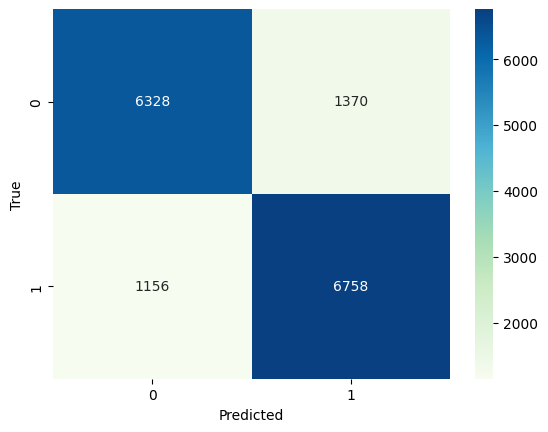

In [69]:
matriz_confusion = confusion_matrix(y_test, y_pred)
sns.heatmap(matriz_confusion,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

Calculo las métricas en el conjunto de evaluación

In [70]:
accuracy = accuracy_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
precision = precision_score(y_test,y_pred)
f1=f1_score(y_test,y_pred,)
print("Accuracy: " + str(accuracy))
print("Recall: " + str(recall))
print("Precision: " + str(precision))
print("f1 score: " + str(f1))

Accuracy: 0.8382013835511145
Recall: 0.8539297447561284
Precision: 0.8314468503937008
f1 score: 0.8425383368657274


#### Grafico del  arbol

In [71]:
plt.figure(figsize=(100,100))
tree.plot_tree(modelo, feature_names=df_trabajo_x.columns.to_list(), filled=True, rounded=True, class_names=['Not cancel','cancel'], max_depth=2)

[Text(0.5769230769230769, 0.875, 'deposit_type_Non Refund <= 0.5\ngini = 0.5\nsamples = 36427\nvalue = [17643, 18784]\nclass = cancel'),
 Text(0.3076923076923077, 0.625, 'lead_time <= 8.5\ngini = 0.491\nsamples = 31125\nvalue = [17628, 13497]\nclass = Not cancel'),
 Text(0.15384615384615385, 0.375, 'required_car_parking_spaces <= 0.5\ngini = 0.278\nsamples = 4024\nvalue = [3353, 671]\nclass = Not cancel'),
 Text(0.07692307692307693, 0.125, '\n  (...)  \n'),
 Text(0.23076923076923078, 0.125, '\n  (...)  \n'),
 Text(0.46153846153846156, 0.375, 'country_PRT <= 0.5\ngini = 0.499\nsamples = 27101\nvalue = [14275, 12826]\nclass = Not cancel'),
 Text(0.38461538461538464, 0.125, '\n  (...)  \n'),
 Text(0.5384615384615384, 0.125, '\n  (...)  \n'),
 Text(0.8461538461538461, 0.625, 'country_DEU <= 0.5\ngini = 0.006\nsamples = 5302\nvalue = [15, 5287]\nclass = cancel'),
 Text(0.7692307692307693, 0.375, 'booking_changes <= 0.5\ngini = 0.001\nsamples = 5290\nvalue = [3, 5287]\nclass = cancel'),
 Tex

In [72]:
#viz_model = dtreeviz.model(modelo, X_train=df_trabajo_x, y_train=s_trabajo_y, feature_names=df_trabajo_x.columns.to_list(), target_name='is_cancelded', class_names=['Not cancel','Cancel'])                          
#v = viz_model.view(scale = 1.5, title = 'Arbol de decisión. Modelo inicial')

#### Exporto csv

In [73]:
df_hotels_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52039 entries, 0 to 61912
Columns: 166 entries, lead_time to customer_type_Transient-Party
dtypes: bool(146), float64(3), int64(17)
memory usage: 15.6 MB


In [74]:
ds_hotels_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26535 entries, 0 to 26534
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           26535 non-null  object 
 1   lead_time                       26535 non-null  int64  
 2   arrival_date_year               26535 non-null  int64  
 3   arrival_date_month              26535 non-null  object 
 4   arrival_date_week_number        26535 non-null  int64  
 5   arrival_date_day_of_month       26535 non-null  int64  
 6   stays_in_weekend_nights         26535 non-null  int64  
 7   stays_in_week_nights            26535 non-null  int64  
 8   adults                          26535 non-null  int64  
 9   children                        26535 non-null  float64
 10  babies                          26535 non-null  int64  
 11  meal                            26535 non-null  object 
 12  country                         

In [75]:
joblib.dump(modelo, 'm1_sin_hiper.joblib')
modelo = joblib.load('m1_sin_hiper.joblib')
y_pred_sin_optimizar = modelo.predict(df_hotels_test)
df_summision = pd.DataFrame({'id': s_id_test, 'is_canceled': y_pred_sin_optimizar})
df_summision.head()

,id,is_canceled
1,aba9aac2-4495-4645-a60e-90328713c999,0
3,ce1b400e-afa1-4946-bdff-004b859eb61c,1
4,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214,1
5,c142b61c-3035-46e7-8cf7-3720a29d0d61,1
7,3ce60033-4529-4314-be77-db4a7737f326,1


#### Exportacion de summision

In [76]:
df_summision.to_csv('summit.csv', index = False)
df_hotels_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52039 entries, 0 to 61912
Columns: 166 entries, lead_time to customer_type_Transient-Party
dtypes: bool(146), float64(3), int64(17)
memory usage: 15.6 MB


#### Poda

Creo un clasificador

In [77]:
arbol_poda = tree.DecisionTreeClassifier(criterion="gini", max_depth=20, min_samples_leaf=10, ccp_alpha=0.01)

Entreno un  modelo

In [78]:
model_poda = arbol_poda.fit(X = x_train, y = y_train)

Realizo una prediccion

In [79]:
y_pred_poda = model_poda.predict(x_test)

Comparo los resultados

In [80]:
ds_resultados_poda = pd.DataFrame(zip(y_test,y_pred_poda),columns=['test','pred'])
ds_resultados_poda.head(10)

,test,pred
0,0,0
1,1,0
2,0,0
3,1,1
4,1,1
5,1,1
6,1,1
7,0,1
8,1,0
9,0,0


Creo matriz de confusion

Text(50.722222222222214, 0.5, 'True')

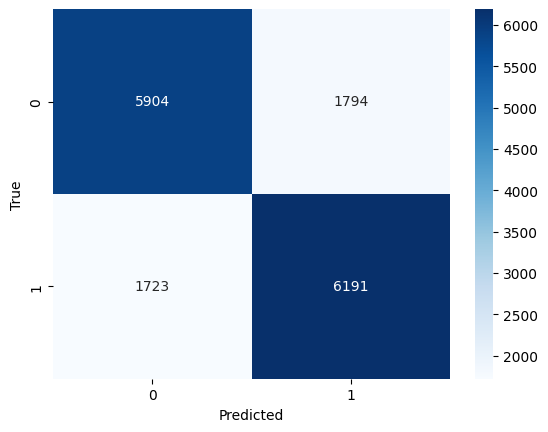

In [81]:
matriz = confusion_matrix(y_test,y_pred_poda)
sns.heatmap(matriz, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

Evaluo la performance en el conjunto de evaluacion

In [82]:
accuracy_poda = accuracy_score(y_test,y_pred_poda)
recall_poda = recall_score(y_test,y_pred_poda)
precision = precision_score(y_test,y_pred_poda)
f1_poda = f1_score(y_test,y_pred_poda)
print("Accuracy: " + str(accuracy_poda))
print("Recall: " + str(recall_poda))
print("Precision: " + str(precision))
print("f1 score: " + str(f1_poda))

Accuracy: 0.7747245708429413
Recall: 0.7822845590093506
f1 score: 0.7787911189382981
Precision: 0.7753287413901064
